In [1]:
import torch 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pymatgen.core import Structure
from cdft.dft3d import dft_core
from cdft.lj_eos import lj_eos

device = torch.device('cuda')

In [2]:
sigma = 3.73
epsilon = 148.0
parameters = {'sigma':sigma, 'epsilon':epsilon}

In [3]:
structure = Structure.from_file('structures/IRMOF-1.cif')
print('formula:        ', structure.formula)
print('num_sites:      ', structure.num_sites)
print('lattice_lengths:', structure.lattice.lengths)

formula:         Zn32 H96 C192 O104
num_sites:       424
lattice_lengths: (25.832, 25.832, 25.832)


/home/lucas/miniforge3/envs/torch/lib/python3.13/site-packages/pymatgen/io/cif.py:1290: UserWarning: Issues encountered while parsing CIF: Skipping relative stoichiometry check because CIF does not contain formula keys.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))


In [4]:
T = 92.0
system_size = np.array([l for l in structure.lattice.lengths])
points = np.array([128, 128, 128])
dft = dft_core(parameters=parameters, temperature=T, system_size=system_size, angles=None, points=points, device=device)
dft.cell_size

array([0.2018125, 0.2018125, 0.2018125])

In [5]:
forcefield = pd.DataFrame()
forcefield['type'] = ['C','H','O','Zn']
forcefield['sigma'] = np.array([3.47299, 2.84642, 3.03315, 2.4615])
forcefield['epsilon'] = np.array([47.8562, 7.64893, 48.1581, 62.3992])

def lj_potential(r,sigma,epsilon):
    return 4.0*epsilon*((sigma/r)**12-(sigma/r)**6) 

rc = 12.9

Vext = torch.zeros_like(dft.X)
U = torch.zeros_like(dft.X)
for k, site in enumerate(structure):
    sigmas = float(forcefield['sigma'][forcefield['type']==site.species_string].values[0])
    epsilons = float(forcefield['epsilon'][forcefield['type']==site.species_string].values[0])
    sigmasf = 0.5*(sigma+sigmas) 
    epsilonsf = np.sqrt(epsilon*epsilons)
    rx = dft.X-structure.cart_coords[k,0] 
    ry = dft.Y-structure.cart_coords[k,1] 
    rz = dft.Z-structure.cart_coords[k,2] 
    rx -= system_size[0]*(rx/system_size[0]).round()
    ry -= system_size[1]*(ry/system_size[1]).round()
    rz -= system_size[2]*(rz/system_size[2]).round()
    r = torch.sqrt(rx**2+ry**2+rz**2)
    U = lj_potential(r,sigmasf,epsilonsf)
    U[r==0] = np.inf
    U[r>rc] = 0.0
    Vext += U

Text(0, 0.5, '$y$ (\\AA{})')

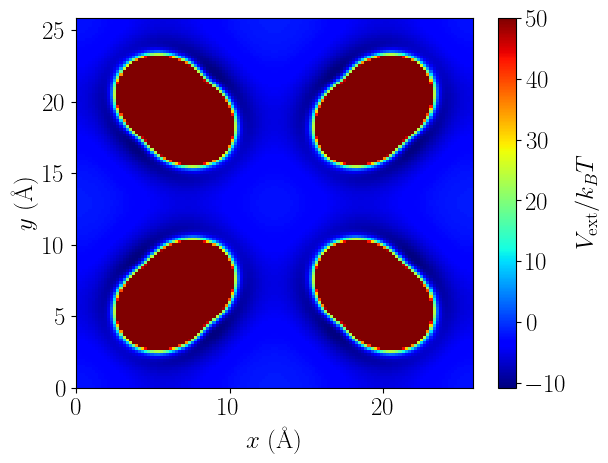

In [6]:
plt.rcParams.update({'text.usetex':True, 
'font.family':'serif', 
'font.size':18, 
# 'axes.linewidth':1.1, 
'lines.linewidth':1.6,
'legend.fontsize': 18,
'legend.frameon':False
#'figure.figsize':(7.9, 6.1)
})


plt.figure()
c=plt.pcolormesh(dft.X[:,:,points[0]//2].cpu(),dft.Y[:,:,points[1]//2].cpu(),Vext[:,:,points[2]//2].cpu()/T,vmax=50.0,cmap='jet')
plt.colorbar(label=r'$V_{\mathrm{ext}}/k_B T$')
plt.xlabel(r'$x$ (\AA{})')
plt.ylabel(r'$y$ (\AA{})')

In [7]:
P0 = 0.013801e6
P = torch.hstack((torch.arange(1e-5,1e-4,1e-5,dtype=torch.float64),torch.arange(1e-4,1e-3,1e-4,dtype=torch.float64),
                 torch.arange(1e-3,1e-2,5e-4,dtype=torch.float64)))*P0
bulk_density = torch.empty_like(P)

eos = lj_eos(parameters, T)
bulk_density[0] = eos.density(P[0],'vap')
for i in range(1,len(P)):
    bulk_density[i] = eos.density(P[i],bulk_density[i-1])

In [8]:
dft.initial_condition(bulk_density[0],Vext)

In [ ]:
Nads = torch.zeros(len(P),dtype=torch.float64)
for i in range(len(P)):
    dft.equilibrium_density_profile(bulk_density[i],fmt='ASWB',solver='picard_ls',tol=1e-6,max_it=1000,logoutput=False)
    # Nads[i] = dft.total_molecules
    # print(dft.it,dft.error.numpy(),P[i].numpy()/P0,Nads[i].numpy())
    # dft.equilibrium_density_profile(bulk_density[i],fmt='ASWB',solver='fire',
    #                                 alpha0=0.1,dt=0.01,tol=1e-6,max_it=1000,logoutput=False)
    Nads[i] = dft.total_molecules
    print(dft.it,dft.error.numpy(),P[i].numpy()/P0,Nads[i].numpy())
    if np.isnan(dft.error.numpy()): break
    else:
        torch.save(dft.rho.cpu(), f'rho.pt')
        torch.save((P,Nads), f'adsorption.pt')

In [11]:
dft.rho = torch.load(f'rho.pt').to(device)
P, Nads = torch.load(f'adsorption.pt')
last = 21

In [12]:
dft.initial_condition(bulk_density[21],Vext)
for i in range(last,len(P)):
    dft.equilibrium_density_profile(bulk_density[i],fmt='ASWB',solver='fire',
                                    alpha0=0.1,dt=0.01,tol=1e-6,max_it=10000,logoutput=True)
    Nads[i] = dft.total_molecules
    print(dft.it,dft.error.numpy(),P[i].numpy()/P0,Nads[i].numpy())
    if np.isnan(dft.error.numpy()): break
    # else:
    #     torch.save(dft.rho.cpu(), f'rho.pt')
    #     torch.save((P,Nads), f'adsorption.pt')

1 tensor(7.8194, device='cuda:0', dtype=torch.float64)
2 tensor(7.8182, device='cuda:0', dtype=torch.float64)
3 tensor(7.8163, device='cuda:0', dtype=torch.float64)
4 tensor(7.8135, device='cuda:0', dtype=torch.float64)
5 tensor(7.8100, device='cuda:0', dtype=torch.float64)
6 tensor(7.8057, device='cuda:0', dtype=torch.float64)
7 tensor(7.8006, device='cuda:0', dtype=torch.float64)
8 tensor(7.7948, device='cuda:0', dtype=torch.float64)
9 tensor(7.7881, device='cuda:0', dtype=torch.float64)
10 tensor(7.7807, device='cuda:0', dtype=torch.float64)
11 tensor(7.7725, device='cuda:0', dtype=torch.float64)
12 tensor(7.7636, device='cuda:0', dtype=torch.float64)
13 tensor(7.7538, device='cuda:0', dtype=torch.float64)
14 tensor(7.7433, device='cuda:0', dtype=torch.float64)
15 tensor(7.7320, device='cuda:0', dtype=torch.float64)
16 tensor(7.7199, device='cuda:0', dtype=torch.float64)
17 tensor(7.7071, device='cuda:0', dtype=torch.float64)
18 tensor(7.6935, device='cuda:0', dtype=torch.float64)
1

In [ ]:
import seaborn as sns

colors = sns.color_palette("mako")

plt.rcParams.update({'text.usetex':True, 
'font.family':'serif',  
#'figure.figsize':(7.9, 6.1)
})

plt.plot(P, Nads, '-', color=colors[3], linewidth=2.0, label='cDFT')
plt.xlabel(r'$P$ (bar)', fontsize=18)
plt.ylabel(r'$N$ (molecules/u.c.)', fontsize=18)
plt.xlim([0.0,100.])
# plt.ylim([None,0.004])
plt.minorticks_on()
plt.tick_params(direction='in',right=True, top=True)
plt.tick_params(labelsize=18)
plt.tick_params(labelbottom=True, labeltop=False, labelright=False, labelleft=True)
plt.tick_params(direction='in',which='minor', length=4, bottom=True, top=True, left=True, right=True)
plt.tick_params(direction='in',which='major', length=8, bottom=True, top=True, left=True, right=True)
plt.legend(fontsize=16, frameon=True, edgecolor='k')
# plt.savefig('figures/isotherm_methane.pdf', bbox_inches='tight')

In [ ]:
plt.figure()
c=plt.pcolormesh(dft.X[:,:,points[0]//2].cpu(),dft.Y[:,:,points[1]//2].cpu(),dft.rho[:,:,points[2]//2].cpu()/dft.rhob.cpu(),cmap='jet',shading='gouraud')
plt.colorbar(c, label=r'$\rho(x,y)/ \rho_b$')
plt.xlabel(r'$x$ (\AA{})')
plt.ylabel(r'$y$ (\AA{})')